## Setup and Imports

In [86]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report



## Loading and Preprocessing the Data

In [87]:
data = pd.read_csv("../data/processed_dataFINAL.csv")

# Convert JSON strings back to Python lists
data['processed_text'] = data['processed_text'].apply(json.loads)

In [88]:
data.head()

,category,rating,label,text,processed_text
0,Home_and_Kitchen,5,CG,"Love this! Well made, sturdy, and very comfor...","[love, well, make, sturdy, comfortable, love, ..."
1,Home_and_Kitchen,5,CG,"love it, a great upgrade from the original. I...","[love, great, upgrade, original, mine, couple,..."
2,Home_and_Kitchen,5,CG,This pillow saved my back. I love the look and...,"[pillow, save, back, love, look, feel, pillow]"
3,Home_and_Kitchen,1,CG,"Missing information on how to use it, but it i...","[miss, information, use, great, product, price]"
4,Home_and_Kitchen,5,CG,Very nice set. Good quality. We have had the s...,"[nice, set, good, quality, set, two, month]"


In [89]:
# Convert 'processed_text' from list to string
data['processed_text_str'] = data['processed_text'].apply(' '.join)


In [90]:
data.head()

,category,rating,label,text,processed_text,processed_text_str
0,Home_and_Kitchen,5,CG,"Love this! Well made, sturdy, and very comfor...","[love, well, make, sturdy, comfortable, love, ...",love well make sturdy comfortable love pretty
1,Home_and_Kitchen,5,CG,"love it, a great upgrade from the original. I...","[love, great, upgrade, original, mine, couple,...",love great upgrade original mine couple year
2,Home_and_Kitchen,5,CG,This pillow saved my back. I love the look and...,"[pillow, save, back, love, look, feel, pillow]",pillow save back love look feel pillow
3,Home_and_Kitchen,1,CG,"Missing information on how to use it, but it i...","[miss, information, use, great, product, price]",miss information use great product price
4,Home_and_Kitchen,5,CG,Very nice set. Good quality. We have had the s...,"[nice, set, good, quality, set, two, month]",nice set good quality set two month


In [91]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')  # Limit to top 1000 features
tfidf_features = tfidf.fit_transform(data['processed_text_str'])

# Convert TF-IDF features to a DataFrame
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf.get_feature_names_out())


In [92]:
# Text length
data['text_length'] = data['text'].apply(len)

# Unique word ratio
data['unique_word_ratio'] = data['processed_text'].apply(lambda tokens: len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0)

# Combine all features
features = pd.concat([tfidf_df, data[['text_length', 'unique_word_ratio', 'rating']]], axis=1)

# One-hot encoding for category
categories = pd.get_dummies(data['category'], prefix='category')
features = pd.concat([features, categories], axis=1)



In [93]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)  # Standardize the features

In [94]:
# Encode labels
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])  # CG -> 0, OR -> 1

In [95]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, data['label_encoded'], test_size=0.2, random_state=42, stratify=data['label_encoded']
)

## Logistic Regression

In [96]:
# Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Predict and evaluate Logistic Regression
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Performance")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

# R² Scores for Logistic Regression
print(f"Logistic Regression R² (Training): {lr.score(X_train, y_train):.2f}")
print(f"Logistic Regression R² (Test): {lr.score(X_test, y_test):.2f}")

Logistic Regression Performance
              precision    recall  f1-score   support

          CG       0.83      0.83      0.83      4044
          OR       0.83      0.83      0.83      4043

    accuracy                           0.83      8087
   macro avg       0.83      0.83      0.83      8087
weighted avg       0.83      0.83      0.83      8087

Logistic Regression R² (Training): 0.85
Logistic Regression R² (Test): 0.83


## Random Forest

In [97]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate Random Forest
y_pred_rf = rf.predict(X_test)
print("Random Forest Performance")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# R² Scores for Random Forest
print(f"Random Forest R² (Training): {rf.score(X_train, y_train):.2f}")
print(f"Random Forest R² (Test): {rf.score(X_test, y_test):.2f}")

Random Forest Performance
              precision    recall  f1-score   support

          CG       0.84      0.86      0.85      4044
          OR       0.86      0.84      0.84      4043

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087

Random Forest R² (Training): 1.00
Random Forest R² (Test): 0.85


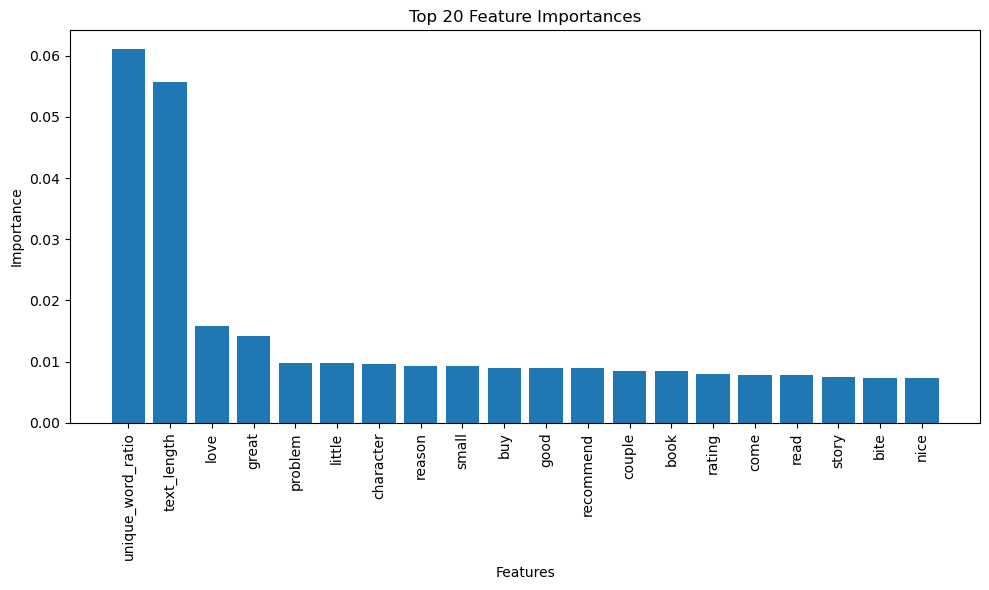

In [100]:
# Map feature importances back to original feature names
importances = rf.feature_importances_  # Get feature importances from the trained Random Forest model
feature_names = features.columns  # Original feature names before scaling
sorted_indices = np.argsort(importances)[::-1]  # Sort indices by importance (descending order)

# Plot only the top 20 features
top_n = 20
plt.figure(figsize=(10, 6))
plt.title(f"Top {top_n} Feature Importances")
plt.bar(range(top_n), importances[sorted_indices][:top_n], align="center")
plt.xticks(range(top_n), feature_names[sorted_indices][:top_n], rotation=90)
plt.ylabel("Importance")
plt.xlabel("Features")
plt.tight_layout()
plt.show()



Random Forest ROC-AUC: 0.93


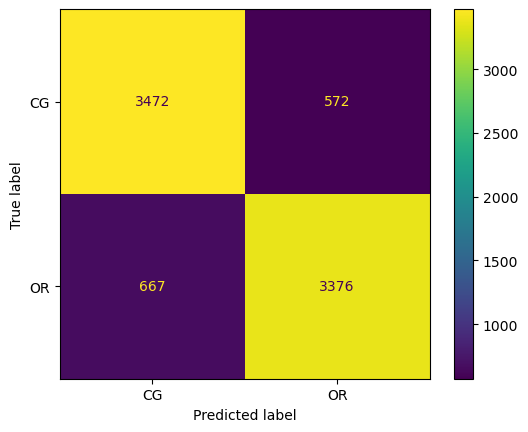

In [101]:
from sklearn.metrics import roc_auc_score, confusion_matrix

# ROC-AUC for Random Forest
roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print(f"Random Forest ROC-AUC: {roc_auc_rf:.2f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=label_encoder.classes_)
plt.show()


# Trying PCA for Dimensionality Reduction

## Apply PCA for Dimensionality Reduction

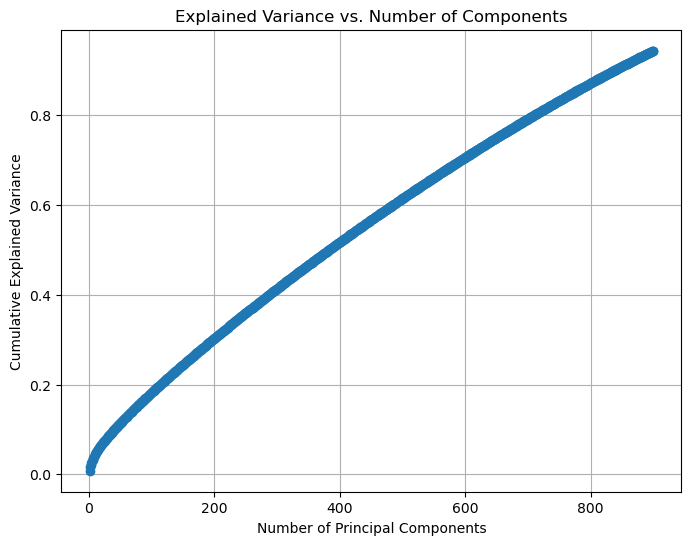

Maximum Cumulative Explained Variance: 0.94


In [118]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Apply PCA
n_components = 900
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Print the maximum cumulative variance
print(f"Maximum Cumulative Explained Variance: {cumulative_variance[-1]:.2f}")


In [119]:
# Find number of components for 95% variance
explained_variance_threshold = 0.95
if cumulative_variance[-1] < explained_variance_threshold:
    print(f"95% variance cannot be achieved even with all components. Max variance: {cumulative_variance[-1]:.2f}")
else:
    optimal_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
    print(f"Number of components needed to retain 95% variance: {optimal_components}")


95% variance cannot be achieved even with all components. Max variance: 0.94


If we reduce the dimensionality to 900 n_components then we get that the Maximum Cumulative Explained Variance: 0.94. This indicates that our dataset's features are not strongly correlated, and no small number of components can explain most of the variance. We could see from the Random Forest feature importance that the most important feature was the "Unique word ratio" but it was only 0.06 which indicates that it will be quite hard to reduce the dimensionality of the dataset features. 

Next we tried to investigate the usage of Gradient Boosting as it can handle high dimensionality. 

## Gradient Boosting